# Introdução

Nesta atividade, o objetivo é desenvolver um modelo de rede neural para detecção de fraudes em transações de cartões de crédito, utilizando o dataset `Credit Card Fraud Detection.` O dataset contém 284.807 amostras e 30 features numéricas, resultantes de uma transformação PCA para garantir a anonimização dos dados. O primeiro passo foi treinar o modelo inicial e avaliar seu desempenho usando métricas como precisão, recall, F1-score e AUC-ROC.

Em seguida, foram definidos intervalos para os hiperparâmetros a serem otimizados. Técnicas de ajuste fino, como grid search e random search, foram aplicadas para melhorar o desempenho do modelo. Por fim, os resultados após a otimização foram comparados aos do modelo original, analisando o impacto das mudanças nos hiperparâmetros com base nas métricas de desempenho.

# 1) Setup

A configuração de setup é o processo de preparar e organizar o ambiente para uso. Envolvendo a instalação de bibliotecas e configuração de outros ajustes necessários. O objetivo é criar um ambiente funcional para executar tarefas específicas.

## 1.1) Instalação das bibliotecas

In [3]:
!pip install scikeras==0.1.8

  Using cached scikeras-0.1.8-py2.py3-none-any.whl.metadata (21 kB)
Using cached scikeras-0.1.8-py2.py3-none-any.whl (19 kB)
  Attempting uninstall: scikeras
    Found existing installation: scikeras 0.8.0
    Uninstalling scikeras-0.8.0:
      Successfully uninstalled scikeras-0.8.0


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [6]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## 1.2) Leitura dos Dados

In [7]:
BASE_CARTAO = pd.read_csv('/content/creditcard.csv')

In [8]:
BASE_CARTAO

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## 1.3) Exploração da Base

*   **Número de Amostras**: 284,807 transações.
*   **Número de Features**: 30, que incluem features numéricas resultantes de uma transformação PCA para anonimização dos dados. A feature "Class" é o rótulo alvo, onde 1 indica uma transação fraudulenta e 0 uma transação legítima.
*   **Tarefa de Classificação**: Prever se uma transação de cartão de crédito é fraudulenta (1) ou legítima (0).


In [9]:
BASE_CARTAO.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Descrição da Coluna**

*   **Time**: Tempo decorrido (em segundos) entre a transação atual e a primeira transação no conjunto de dados.
*   **V1, V2, ..., V28**: Essas colunas representam componentes principais obtidos através de uma técnica de redução de dimensionalidade chamada PCA (Principal Component Analysis). Os valores não têm uma interpretação direta como variáveis de domínio.
*   **Amount**: O valor monetário da transação.
*   **Class**: A variável alvo, onde 0 indica uma transação normal e 1 indica uma transação fraudulenta.

### 1.3.1) Verificar Valores Ausentes

In [10]:
VALORES_AUSENTES = BASE_CARTAO.isnull().sum()

In [11]:
VALORES_AUSENTES

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


### 1.3.2) Balanceamento dos Dados

O método abaixo reduz o número de amostras da classe majoritária para igualar a quantidade da classe minoritária.

In [12]:
rus = RandomUnderSampler()

X = BASE_CARTAO.drop('Class', axis=1)
y = BASE_CARTAO['Class']

X_res, y_res = rus.fit_resample(X, y)

DF_TRATADO = pd.concat([X_res, y_res], axis=1)

In [13]:
DF_TRATADO

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
239399,150090.0,-1.148633,-0.277166,3.103466,-0.829011,-0.142803,1.122112,-0.379783,0.308389,1.705404,...,-0.017483,0.580531,-0.227510,0.566484,0.587111,0.732499,-0.204822,-0.198067,0.01,0
146374,87643.0,-1.806617,0.707272,0.845979,-1.380652,0.731582,1.988473,0.255196,1.026573,0.199331,...,-0.314387,-0.617294,0.166422,-0.786923,0.424836,-0.865435,0.094281,-0.028381,71.96,0
150993,94330.0,-1.888723,0.223984,1.381839,-0.758260,1.514985,-1.391024,0.239206,-0.105123,1.082243,...,-0.526913,-1.105413,-0.593517,0.022380,0.450376,0.184537,0.085586,0.015872,0.99,0
41126,40547.0,-1.036951,-0.137576,3.422080,0.438118,-0.438494,0.697545,0.154275,0.031645,1.262522,...,-0.014967,0.670709,-0.224543,0.581142,0.199072,-0.497198,-0.285144,-0.322509,46.90,0
55486,46963.0,-1.506466,2.270183,-2.104791,-0.267842,2.317861,4.006292,-2.329840,-3.990319,-1.671893,...,-2.555178,0.459316,0.260057,0.859760,-0.258899,0.414744,-0.065254,0.171033,0.76,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


## 1.4) Preparação dos Dados

Inicialmente é realizada a remoção da coluna "Class" e o armazenamento do restante das features em X. Essas features são os atributos que o modelo utilizará para fazer as previsões. Já em y é armazenada a coluna "Class", que representa o rótulo a ser previsto (fraude ou não).


In [14]:
X = DF_TRATADO.drop('Class', axis=1)
y = DF_TRATADO['Class']

**Dividindo os dados em conjunto de treino e teste**

É realizada a divisão de X e y em conjuntos de treino (80%) e teste (20%), garantindo a mesma proporção de fraudes e não-fraudes em ambos.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Normalizando as features**

É realizada a normalização das features para que tenham média 0 e desvio padrão 1, melhorando a performance do modelo.

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2) Modelo Inicial

## 2.2) Construindo o Modelo

Na função abaixo, é definido e compilado um modelo sequencial de rede neural com duas camadas ocultas e uma camada de saída para classificação binária.

In [17]:
def criarModelo():
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Abaixo é criado um modelo neural.

In [18]:
model = criarModelo()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


O modelo é treinado com os dados de treino (X_train e y_train) por 5 épocas, sendo 20% dos dados para validação.

In [19]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4760 - loss: 0.7044 - val_accuracy: 0.7152 - val_loss: 0.6347
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7464 - loss: 0.5945 - val_accuracy: 0.8291 - val_loss: 0.5425
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8445 - loss: 0.5172 - val_accuracy: 0.8924 - val_loss: 0.4691
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8559 - loss: 0.4518 - val_accuracy: 0.8924 - val_loss: 0.4068
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8722 - loss: 0.3896 - val_accuracy: 0.8987 - val_loss: 0.3639
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8796 - loss: 0.3376 - val_accuracy: 0.8924 - val_loss: 0.3330
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8815 - loss: 0.3313 - val_accuracy: 0.8924 - val_loss: 0.3109
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8868 - loss: 0.3081 - val_accuracy: 0.9051 - val_loss

## 2.3) Avaliação do Modelo

In [20]:
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


É gerado um relatório de classificação com métricas como precisão, recall e F1-score, comparando as previsões com os dados reais de teste.

In [21]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        99
           1       0.96      0.93      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



É calculada a área sob a curva ROC para avaliar a performance do modelo.

In [22]:
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

AUC-ROC: 0.9820655534941249


Por fim, é plotada a curva ROC para visualizar a relação entre a taxa de verdadeiros positivos e falsos positivos do modelo.

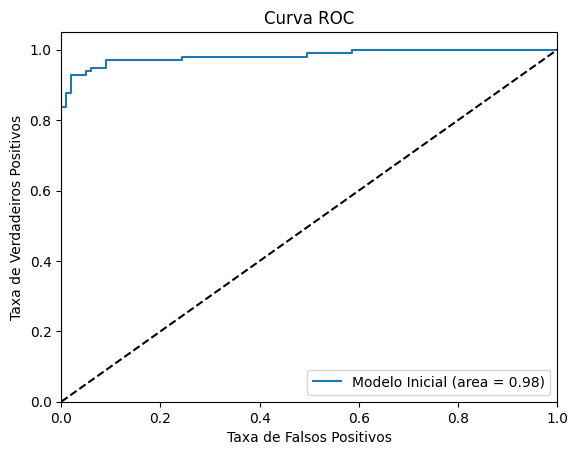

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='Modelo Inicial (area = %0.2f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# 3) Modelo Otimizado

## 3.1) Construindo o Modelo

A função abaixo, define e compila um modelo sequencial de rede neural com parâmetros ajustáveis para o otimizador e número de neurônios, permitindo flexibilidade para otimização de hiperparâmetros.

In [24]:
def ajusteModelo(neurons=16, optimizer='adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(neurons // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [25]:
model = KerasClassifier(build_fn=ajusteModelo, verbose=0)

Abaixo é definido um dicionário de parâmetros para ajuste de hiperparâmetros, incluindo batch size, épocas, otimizadores e número de neurônios.

In [26]:
param_grid = {
    'neurons': [32, 64, 128],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32, 64]
}

Abaixo é configurada uma busca em grade para otimização de hiperparâmetros utilizando validação cruzada, com o objetivo de encontrar a melhor combinação de parâmetros para maximizar a acurácia.

In [27]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)

É realizada a execução da busca em grade para ajustar o modelo com diferentes combinações de hiperparâmetros usando os dados de treino.

In [ ]:
grid_result = grid.fit(X_train, y_train)

É exibida a melhor pontuação de acurácia e a combinação correspondente de hiperparâmetros que resultaram nessa pontuação.

In [ ]:
print(f"Melhor: {grid_result.best_score_} usando {grid_result.best_params_}")

 Por fim, é realiza a conversão da função `ajusteModelo` em um objeto KerasClassifier para permitir integração com o GridSearchCV.

In [ ]:
model = KerasClassifier(build_fn=ajusteModelo, verbose=0)

## 3.2) Avaliação do Modelo

Abaixo, é recuperado o modelo com os melhores hiperparâmetros encontrados pela busca.

In [ ]:
best_model = grid_result.best_estimator_

O modelo otimizado é utilizado para fazer previsões nos dados de teste.

In [ ]:
y_pred_opt = best_model.predict(X_test)

É gerado um relatório de classificação com métricas de desempenho, como precisão, recall e F1-score, usando as previsões otimizadas e os dados reais de teste.

In [ ]:
print(classification_report(y_test, y_pred_opt))

É calculada a área sob a curva ROC para avaliar a performance do modelo otimizado com as previsões feitas nos dados de teste.

In [ ]:
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_opt)}")

Por fim, é plotada a curva ROC para o modelo otimizado, visualizando a relação entre a taxa de verdadeiros positivos e falsos positivos para diferentes limiares de classificação.







In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='Modelo Otimizado (area = %0.2f)' % roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# 4) Comparação dos Modelos

É a AUC-ROC e o relatório de classificação (incluindo precisão, recall, F1-score) para o modelo inicial e para o modelo otimizado, utilizando as previsões realizadas nos dados de teste.

In [ ]:
print("Modelo Inicial:")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred_class))

In [ ]:
print("\nModelo Otimizado:")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_opt)}")
print(classification_report(y_test, y_pred_opt))